In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
# Import data
dataset = pd.read_csv('E:\Programming\Python\Dataset\Health_Cost\insurance.csv')
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [3]:
# Creating the label decoding for region
region = dataset.region.astype('category')
label_encoding_region = dict(enumerate(region.cat.categories))
print (label_encoding_region)

# Creating the label decoding for smoker
smoker = dataset.smoker.astype('category')
label_encoding_smoker = dict(enumerate(smoker.cat.categories))
print (label_encoding_smoker)

# Creating the label decoding for sex
sex = dataset.sex.astype('category')
label_encoding_sex = dict(enumerate(sex.cat.categories))
print (label_encoding_sex)

{0: 'northeast', 1: 'northwest', 2: 'southeast', 3: 'southwest'}
{0: 'no', 1: 'yes'}
{0: 'female', 1: 'male'}


The above code helps us to keep track of key-value pair of all the encoding we have created

In [4]:
# Encoding the region column through label decoding
dataset["region"] = dataset["region"].astype('category')
dataset["region"] = dataset["region"].cat.codes

# Encoding the smoker column through label decoding
dataset["smoker"] = dataset["smoker"].astype('category')
dataset["smoker"] = dataset["smoker"].cat.codes

# # Encoding the sex column through label decoding
dataset["sex"] = dataset["sex"].astype('category')
dataset["sex"] = dataset["sex"].cat.codes

In [5]:
dataset.head()

,age,sex,bmi,children,smoker,region,expenses
0,19,0,27.9,0,1,3,16884.92
1,18,1,33.8,1,0,2,1725.55
2,28,1,33.0,3,0,2,4449.46
3,33,1,22.7,0,0,1,21984.47
4,32,1,28.9,0,0,1,3866.86


In [6]:
# Dividing the original dataset into training and testing dataset with a ratio of 0.8
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

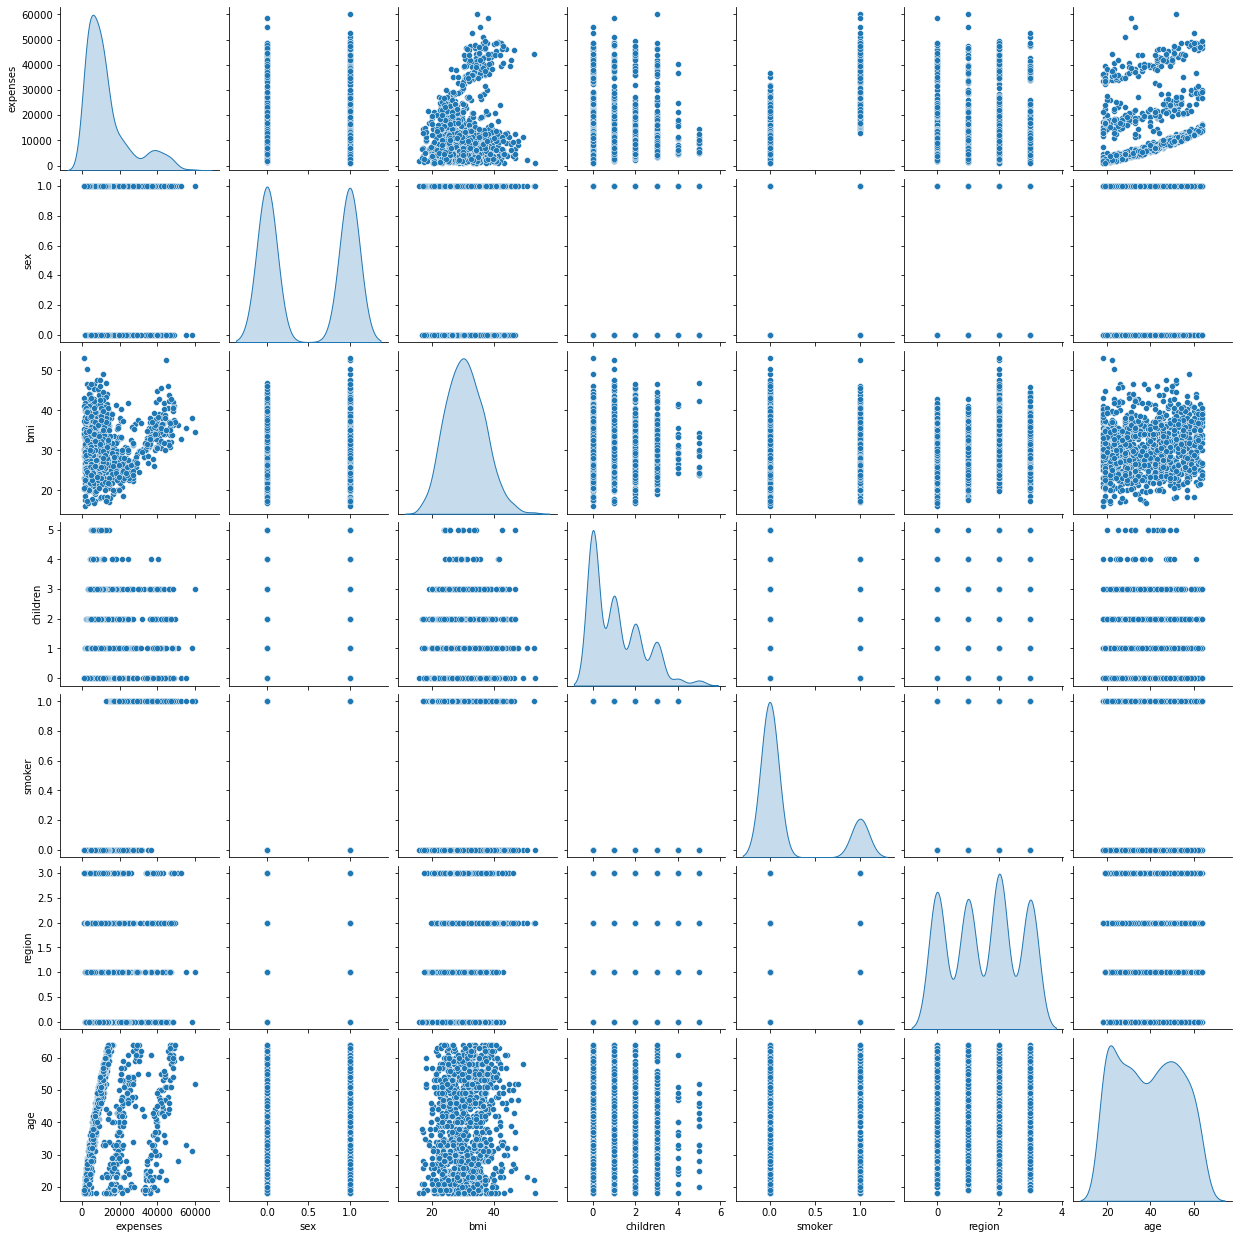

In [7]:
# To check how our columns in the dataset correlate with each other
sns.pairplot(train_dataset[['expenses', 'sex', 'bmi', 'children','smoker','region','age']], diag_kind='kde')

In [8]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,1070.0,39.036449,14.142122,18.00,26.000,39.000,51.0000,64.0
sex,1070.0,0.498131,0.500230,0.00,0.000,0.000,1.0000,1.0
bmi,1070.0,30.737290,6.065193,16.00,26.300,30.500,34.8000,53.1
children,1070.0,1.093458,1.211364,0.00,0.000,1.000,2.0000,5.0
smoker,1070.0,0.199065,0.399484,0.00,0.000,0.000,0.0000,1.0
region,1070.0,1.501869,1.103399,0.00,1.000,2.000,2.0000,3.0
expenses,1070.0,13056.551654,11994.260172,1121.87,4565.995,9289.085,15826.1125,60021.4


In [9]:
# Separating our features and labels
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

### Normalization
It is good practice to normalize features that use different scales and ranges. One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs.

In [10]:
# Creating the Normalization layer
normalizer = preprocessing.Normalization()

In [11]:
# Fits the state of the preprocessing layer to the data being passed
normalizer.adapt(np.array(train_features))

In [12]:
# This calculates the mean and variance, and stores them in the layer.
print(normalizer.mean.numpy())

[39.03645     0.49813083 30.73729     1.0934579   0.19906542  1.5018692 ]


In [13]:
# When the layer is called it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[52.   1.  30.2  1.   0.   3. ]]

Normalized: [[ 0.92  1.   -0.09 -0.08 -0.5   1.36]]


In [14]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=['mae','mse'])
  return model

In [15]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.build((1070, 6))
dnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization multiple                  13        
_________________________________________________________________
dense (Dense)                multiple                  448       
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 4,686
Trainable params: 4,673
Non-trainable params: 13
_________________________________________________________________


In [16]:
history = dnn_model.fit(
    train_features.values, train_labels.values,
    validation_split=0.2,
    verbose=0, epochs=150)

In [17]:
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = dnn_model.evaluate(test_features, test_labels, verbose=2)
print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

268/268 - 0s - loss: 3375.3234 - mae: 3375.3235 - mse: 48492084.0000
Testing set Mean Abs Error: 3375.32 expenses


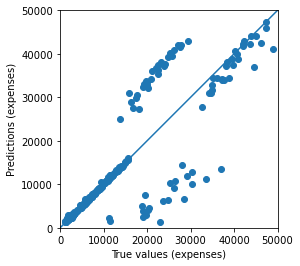

In [18]:
# Plot predictions.
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)